In [3]:
import pandas as pd

CAMINHO = "../data/Customers_clustered.csv"

df_clustered = pd.read_csv(CAMINHO)

df_clustered

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,TotalNumPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,Partner,61223.0,0,1,46,709,43,182,42,...,47,46-60,1341,1094,1,1,0,0,16,0
2236,PhD,Partner,64014.0,2,1,56,406,0,30,0,...,68,61+,444,436,3,1,1,1,15,2
2237,Graduation,Single,56981.0,0,0,91,908,48,217,32,...,33,31-45,1241,1217,0,0,1,1,18,0
2238,Master,Partner,69245.0,0,1,8,428,30,214,80,...,58,46-60,843,782,1,1,0,0,21,0


In [4]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   object 
 1   Marital_Status       2240 non-null   object 
 2   Income               2240 non-null   float64
 3   Kidhome              2240 non-null   int64  
 4   Teenhome             2240 non-null   int64  
 5   Recency              2240 non-null   int64  
 6   MntWines             2240 non-null   int64  
 7   MntFruits            2240 non-null   int64  
 8   MntMeatProducts      2240 non-null   int64  
 9   MntFishProducts      2240 non-null   int64  
 10  MntSweetProducts     2240 non-null   int64  
 11  MntGoldProds         2240 non-null   int64  
 12  NumDealsPurchases    2240 non-null   int64  
 13  NumWebPurchases      2240 non-null   int64  
 14  NumCatalogPurchases  2240 non-null   int64  
 15  NumStorePurchases    2240 non-null   i

In [5]:
# separar em X e y
X = df_clustered.drop("Response", axis=1)
y = df_clustered.Response

In [6]:
# colunas que passaram por one hot encoding

# vars categóricas (discretas)
onehot_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
    "cluster"
]

# vars de distribuicao semelhante à gaussiana
standard_cols = [
    "Income",
    "Age"
]

# vars de distribuicao semelhante à exponenciais
power_cols = X.columns[(X.columns.str.startswith("Mnt")) | (X.columns.str.startswith("Num"))].tolist()

# vars uniformes passarão pela normalização minmax
minmax_cols = [col for col in X.columns if col not in onehot_cols + standard_cols + power_cols]

In [7]:
# selecionando modelos para teste
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline # feita para lidar com dados desbalanceados
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate


RANDOM_STATE = 42

# aplicar ideia de validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# definir pipeline

# definir preprocessamento
preprocessing = ColumnTransformer(
[
    ("onehot", OneHotEncoder(), onehot_cols),
    ("standar", StandardScaler(), standard_cols),
    ("power", PowerTransformer(), power_cols),
    ("minmax", MinMaxScaler(), minmax_cols)
]
)

# definir pipeline em si
pipeline_logreg = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
        ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
        ("model", LogisticRegression(random_state=RANDOM_STATE))
    ]
)

pipeline_logreg.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Kidhome', 'Teenhome',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'AcceptedCmpTotal',
                                                   'cluster']),
                                                 ('standar', Standa...
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal',
                                                   'MntRegularProds']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysSinceEnrolled',
                                                   'TotalNumPurchases'])])),
                ('feature_selection', SelectKBest()),
                ('rus', RandomUnderSampler(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

In [11]:
pipeline_logreg[:-1].feature_names_in_

array(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'DaysSinceEnrolled', 'YearsSinceEnrolled', 'Age',
       'AgeGroup', 'MntTotal', 'MntRegularProds', 'Children',
       'HasChildren', 'AcceptedCmpTotal', 'HasAcceptedCmp',
       'TotalNumPurchases', 'cluster'], dtype=object)

In [12]:
pipeline_logreg[:-1].get_feature_names_out()

array(['onehot__HasAcceptedCmp_0', 'onehot__HasAcceptedCmp_1',
       'onehot__AcceptedCmp1_0', 'onehot__AcceptedCmp1_1',
       'onehot__AcceptedCmp3_0', 'onehot__AcceptedCmp3_1',
       'onehot__AcceptedCmp5_0', 'onehot__AcceptedCmp5_1',
       'onehot__AcceptedCmpTotal_0', 'onehot__AcceptedCmpTotal_3'],
      dtype=object)

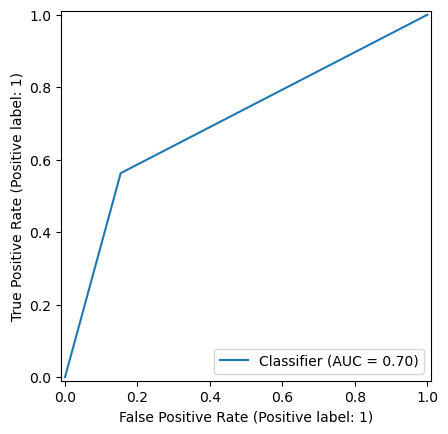

In [15]:
# ROC
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict # não é utilizado para comparar modelos, apenas para gerar visualizações


y_pred = cross_val_predict(pipeline_logreg, X, y, cv=skf, n_jobs=-2)

roc = RocCurveDisplay.from_predictions(y, y_pred)

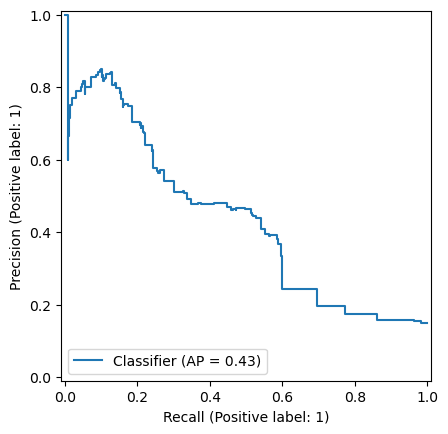

In [16]:
# Precision Recall
from sklearn.metrics import PrecisionRecallDisplay # interessante para avaliar datasets com dados desbalanceados


y_pred = cross_val_predict(pipeline_logreg, X, y, cv=skf, n_jobs=-2, method="decision_function")

pr = PrecisionRecallDisplay.from_predictions(y, y_pred)

In [17]:
pipeline_logreg.named_steps

{'preprocessing': ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                  ['Education', 'Marital_Status', 'AgeGroup',
                                   'HasChildren', 'HasAcceptedCmp',
                                   'AcceptedCmp1', 'AcceptedCmp2',
                                   'AcceptedCmp3', 'AcceptedCmp4',
                                   'AcceptedCmp5', 'Complain', 'Kidhome',
                                   'Teenhome', 'YearsSinceEnrolled', 'Children',
                                   'AcceptedCmpTotal', 'cluster']),
                                 ('standar', StandardScaler(),
                                  ['Income', 'Age']),
                                 ('power', PowerTransformer(),
                                  ['MntWines', 'MntFruits', 'MntMeatProducts',
                                   'MntFishProducts', 'MntSweetProducts',
                                   'MntGoldProds', 'NumDealsPurchases',
              

In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV


param_grid = {
    "feature_selection__k": [10, 15, 20, 25],
    "model__C": np.logspace(-3, 3, 7),
    "model__solver": ["lbfgs", "liblinear", "saga"],
    "model__penalty": [None, "l1", "l2", "elasticnet"]
}

gs = GridSearchCV(pipeline_logreg, param_grid, scoring=["roc_auc", "average_precision", "accuracy"], n_jobs=-2, refit="average_precision")

In [19]:
gs

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'AgeGroup',
                                                                          'HasChildren',
                                                                          'HasAcceptedCmp',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'Complain',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'YearsSinceEnrolled',
                                                                          'Children',
                                                                          'AcceptedCmpTotal',
                                                                          'clust...
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-2,
             param_grid={'feature_selection__k': [10, 15, 20, 25],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': [None, 'l1', 'l2', 'elasticnet'],
                         'model__solver': ['lbfgs', 'liblinear', 'saga']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

In [21]:
import warnings

warnings.filterwarnings("ignore")

gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'AgeGroup',
                                                                          'HasChildren',
                                                                          'HasAcceptedCmp',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'Complain',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'YearsSinceEnrolled',
                                                                          'Children',
                                                                          'AcceptedCmpTotal',
                                                                          'clust...
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-2,
             param_grid={'feature_selection__k': [10, 15, 20, 25],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': [None, 'l1', 'l2', 'elasticnet'],
                         'model__solver': ['lbfgs', 'liblinear', 'saga']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

In [22]:
gs.best_params_

{'feature_selection__k': 25,
 'model__C': 10.0,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [23]:
gs.best_score_

0.6099901711927533

In [31]:
print(*gs.cv_results_.keys(), sep="\n")

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_feature_selection__k
param_model__C
param_model__penalty
param_model__solver
params
split0_test_roc_auc
split1_test_roc_auc
split2_test_roc_auc
split3_test_roc_auc
split4_test_roc_auc
mean_test_roc_auc
std_test_roc_auc
rank_test_roc_auc
split0_test_average_precision
split1_test_average_precision
split2_test_average_precision
split3_test_average_precision
split4_test_average_precision
mean_test_average_precision
std_test_average_precision
rank_test_average_precision
split0_test_accuracy
split1_test_accuracy
split2_test_accuracy
split3_test_accuracy
split4_test_accuracy
mean_test_accuracy
std_test_accuracy
rank_test_accuracy


In [34]:
np.nanmax(gs.cv_results_["mean_test_average_precision"])

0.6099901711927533

In [35]:
np.nanmax(gs.cv_results_["mean_test_roc_auc"])

0.8679681942910928

In [36]:
np.nanmax(gs.cv_results_["mean_test_accuracy"])

0.8508928571428571

In [39]:
gs.cv_results_["params"][np.nanargmax(gs.cv_results_["mean_test_average_precision"])]

{'feature_selection__k': 25,
 'model__C': 10.0,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [40]:
gs.cv_results_["params"][np.nanargmax(gs.cv_results_["mean_test_roc_auc"])]

{'feature_selection__k': 25,
 'model__C': 1000.0,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs'}

In [41]:
gs.cv_results_["params"][np.nanargmax(gs.cv_results_["mean_test_accuracy"])]

{'feature_selection__k': 10,
 'model__C': 0.001,
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

In [42]:
df_results_gs = pd.DataFrame(
    {
        "auprc": gs.cv_results_["mean_test_average_precision"],
        "auroc": gs.cv_results_["mean_test_roc_auc"],
        "accuracy": gs.cv_results_["mean_test_accuracy"],
    }
)

df_results_gs

,auprc,auroc,accuracy
0,0.403941,0.730587,0.814286
1,NaN,NaN,NaN
2,0.403745,0.730563,0.814286
3,NaN,NaN,NaN
4,0.149107,0.500000,0.850893
...,...,...,...
331,0.602416,0.867733,0.796429
332,0.609813,0.867431,0.794643
333,NaN,NaN,NaN
334,NaN,NaN,NaN


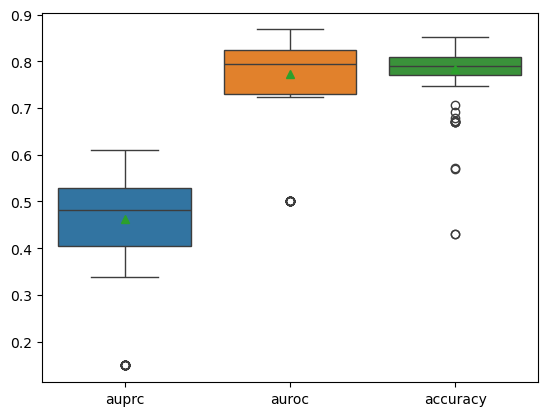

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.boxplot(df_results_gs, showmeans=True)

plt.show()

In [45]:
gs.best_params_

{'feature_selection__k': 25,
 'model__C': 10.0,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [48]:
# retreinando com os parâmetros do gridsearchcv

pipeline_logreg_best = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif, k=gs.best_params_["feature_selection__k"])),
        ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
        ("model", LogisticRegression(random_state=RANDOM_STATE, 
                                     C=gs.best_params_["model__C"], 
                                     penalty=gs.best_params_["model__penalty"],
                                     solver=gs.best_params_["model__solver"]))
    ]
)

scores = cross_validate(
    pipeline_logreg_best,
    X, 
    y,
    cv=skf,
    scoring=["accuracy", "precision","recall","roc_auc","average_precision"],
    n_jobs=-2
)

In [50]:
from pprint import pprint


pprint(scores)

{'fit_time': array([0.10435939, 0.12458873, 0.10942149, 0.11646533, 0.10865474]),
 'score_time': array([0.04121256, 0.04414868, 0.04734659, 0.0456183 , 0.03980279]),
 'test_accuracy': array([0.79241071, 0.78125   , 0.79241071, 0.80357143, 0.79464286]),
 'test_average_precision': array([0.60384113, 0.58561184, 0.58780419, 0.61186591, 0.62614506]),
 'test_precision': array([0.3984375 , 0.37190083, 0.39516129, 0.42335766, 0.40151515]),
 'test_recall': array([0.76119403, 0.67164179, 0.73134328, 0.86567164, 0.8030303 ]),
 'test_roc_auc': array([0.8704509 , 0.83315705, 0.86308614, 0.8832021 , 0.88795018])}


In [52]:
scores["time"] = scores["fit_time"]+ scores["score_time"]

pprint(scores)

{'fit_time': array([0.10435939, 0.12458873, 0.10942149, 0.11646533, 0.10865474]),
 'score_time': array([0.04121256, 0.04414868, 0.04734659, 0.0456183 , 0.03980279]),
 'test_accuracy': array([0.79241071, 0.78125   , 0.79241071, 0.80357143, 0.79464286]),
 'test_average_precision': array([0.60384113, 0.58561184, 0.58780419, 0.61186591, 0.62614506]),
 'test_precision': array([0.3984375 , 0.37190083, 0.39516129, 0.42335766, 0.40151515]),
 'test_recall': array([0.76119403, 0.67164179, 0.73134328, 0.86567164, 0.8030303 ]),
 'test_roc_auc': array([0.8704509 , 0.83315705, 0.86308614, 0.8832021 , 0.88795018]),
 'time': array([0.14557195, 0.16873741, 0.15676808, 0.16208363, 0.14845753])}


In [53]:
df_scores_best = pd.DataFrame(scores)

df_scores_best

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,0.104359,0.041213,0.792411,0.398438,0.761194,0.870451,0.603841,0.145572
1,0.124589,0.044149,0.781250,0.371901,0.671642,0.833157,0.585612,0.168737
2,0.109421,0.047347,0.792411,0.395161,0.731343,0.863086,0.587804,0.156768
3,0.116465,0.045618,0.803571,0.423358,0.865672,0.883202,0.611866,0.162084
4,0.108655,0.039803,0.794643,0.401515,0.803030,0.887950,0.626145,0.148458


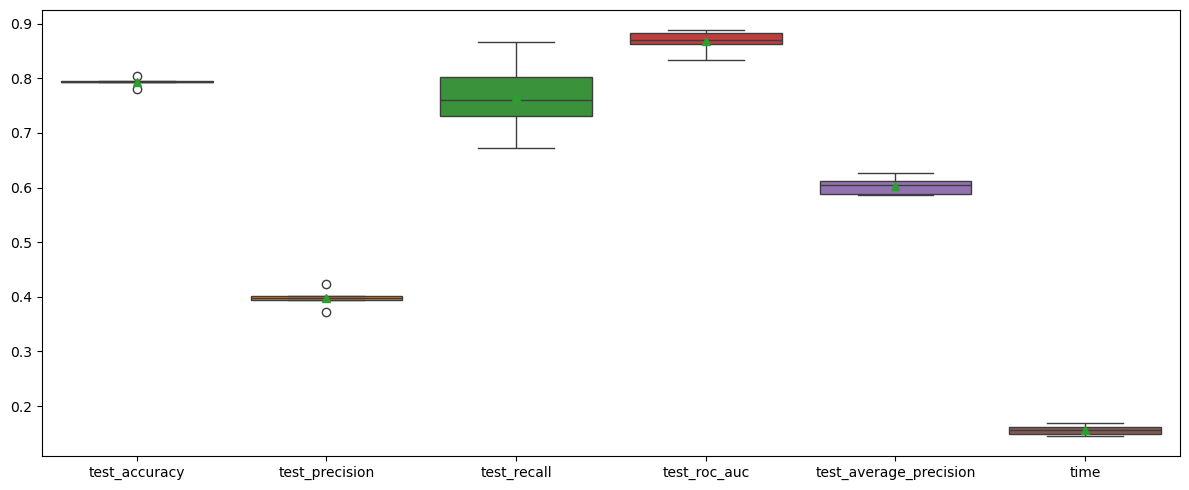

In [65]:
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

b = sns.boxplot(df_scores_best.drop(["fit_time", "score_time"], axis=1), showmeans=True, ax=ax)
b.set_xticklabels(b.get_xticklabels(), fontsize=10)
plt.show()

In [66]:
pipeline_logreg_best.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Kidhome', 'Teenhome',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'AcceptedCmpTotal',
                                                   'cluster']),
                                                 ('standar', Standa...
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal',
                                                   'MntRegularProds']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysSinceEnrolled',
                                                   'TotalNumPurchases'])])),
                ('feature_selection', SelectKBest(k=25)),
                ('rus', RandomUnderSampler(random_state=42)),
                ('model',
                 LogisticRegression(C=10.0, random_state=42,
                                    solver='liblinear'))])

In [68]:
names= pipeline_logreg_best[:-1].get_feature_names_out()

names

array(['onehot__HasChildren_0', 'onehot__HasChildren_1',
       'onehot__HasAcceptedCmp_0', 'onehot__HasAcceptedCmp_1',
       'onehot__AcceptedCmp1_0', 'onehot__AcceptedCmp1_1',
       'onehot__AcceptedCmp3_0', 'onehot__AcceptedCmp3_1',
       'onehot__AcceptedCmp4_0', 'onehot__AcceptedCmp4_1',
       'onehot__AcceptedCmp5_0', 'onehot__AcceptedCmp5_1',
       'onehot__Children_0', 'onehot__AcceptedCmpTotal_0',
       'onehot__AcceptedCmpTotal_1', 'onehot__AcceptedCmpTotal_2',
       'onehot__AcceptedCmpTotal_3', 'power__MntWines',
       'power__MntMeatProducts', 'power__MntGoldProds',
       'power__NumCatalogPurchases', 'power__MntTotal',
       'power__MntRegularProds', 'minmax__Recency',
       'minmax__DaysSinceEnrolled'], dtype=object)

In [69]:
len(names)

25

In [72]:
importance = pipeline_logreg_best["model"].coef_[0]
importance

array([ 0.36090968,  0.01114252, -0.7071051 ,  1.07915729, -0.14600928,
        0.51806148, -0.41202461,  0.78407681,  0.02124176,  0.35081043,
        0.04873657,  0.32331563,  0.36090968, -0.7071051 , -1.44720661,
       -1.06403111, -0.13498818,  0.65435478,  1.11610214, -0.05539523,
        0.61296164,  3.08243068, -4.96845491, -3.12930181,  3.1394458 ])

In [74]:
'''
Considerando o algoritmo de regressão linear, quanto mais negativo o peso, mais auxiliou a classificar como 0 e quanto mais positivo, 
mais auxiliou a classificar como 1
A leve diferença de escalas entre o minmax e o powerscaler pode ter levado a algumas diferenças no peso das features. Porém, essas diferenças
não devem ter levado a grandes diferenças, considerando a mesma ordem de grandeza entre elas
'''

df_importance = pd.DataFrame({
    "name": names,
    "importance": importance
})

df_importance.sort_values("importance", ascending=False)

,name,importance
24,minmax__DaysSinceEnrolled,3.139446
21,power__MntTotal,3.082431
18,power__MntMeatProducts,1.116102
3,onehot__HasAcceptedCmp_1,1.079157
7,onehot__AcceptedCmp3_1,0.784077
17,power__MntWines,0.654355
20,power__NumCatalogPurchases,0.612962
5,onehot__AcceptedCmp1_1,0.518061
0,onehot__HasChildren_0,0.360910
12,onehot__Children_0,0.360910


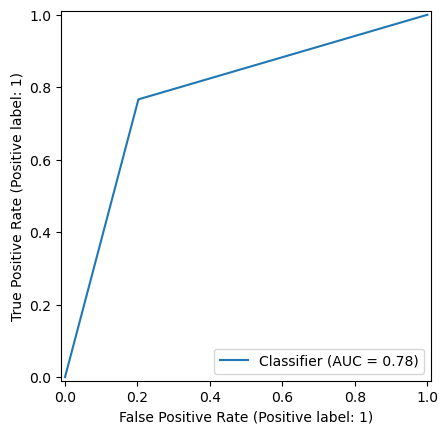

In [75]:
# ROC
y_pred = cross_val_predict(pipeline_logreg_best, X, y, cv=skf, n_jobs=-2)

roc = RocCurveDisplay.from_predictions(y, y_pred)

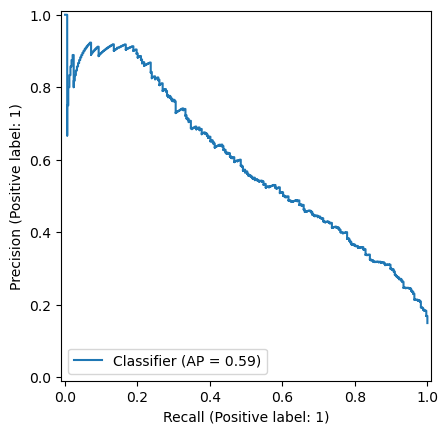

In [76]:
# AUPRC
y_pred = cross_val_predict(pipeline_logreg_best, X, y, cv=skf, n_jobs=-2, method="decision_function")

pr = PrecisionRecallDisplay.from_predictions(y, y_pred)